# Libraries

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from pprint import pprint

from src.utils import (
    # Old utils
    print_h, eval_window, eval_person_majority_voting,

    # New utils
    set_seed, get_device, init_model, init_metrics, update_metrics, save_metrics_to_json,
    plot_k_fold_roc_curves_multiclass_v2, plot_k_fold_cm,
)
from src.models import HardMoE

/home/mitlab/miniconda3/envs/alxxtexxr_py312_torch22/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
# Project config
seed = 69
set_seed(seed)
device = get_device()
print("Device:", device)

# Model config
expert_model_path_map = {
    'Ga': 'checkpoints/RNNInceptionTime_bidirectional_Ga_k10_w500_s500_e20_v20250520224322/fold_06.pth',
    'Ju': 'checkpoints/RNNInceptionTime_bidirectional_Ju_k10_w500_s500_w_anomaly_e5_v20250529001340/fold_06.pth',
    'Si': 'checkpoints/RNNInceptionTime_bidirectional_Si_k10_w500_s250_w_anomaly_e30_v20250529213629/fold_06.pth',
}

# Get model names and parameters
expert_names = [expert_model_dir.split('/')[-2].split('_'+study)[0] for study, expert_model_dir in expert_model_path_map.items()]
assert len(set(expert_names)) == 1, f"Expert model names are inconsistent: {expert_names}"
expert_name = expert_names[0]
if 'bidirectional' in expert_name:
    expert_name = expert_name.replace('_bidirectional', '')
    expert_bidirectional = True
else:
    expert_bidirectional = False
print("Expert model name:", expert_name)
print("Expert model bidirectional:", expert_bidirectional)

# gate_model_path = 'checkpoints/RNNInceptionTimeGate_bidirectional_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_e100_v20250531134858/fold_06.pth' # RNN-InceptionTime
gate_model_path = 'checkpoints/MLPGate_l2_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_fold_06_e20_v20250602215409/fold_06.pth' # MLP

gate_layers = [500, 500]
gate_ps = [0.1, 0.2]

# Data config
fold_i_dir_map = {
    'Ga': f'data/preprocessed/Ga_k10_w500_s500_v20250501004633/fold_06',
    'Ju': f'data/preprocessed/Ju_k10_w500_s500_w_anomaly_v20250501004735/fold_06',
    'Si': f'data/preprocessed/Si_k10_w500_s250_w_anomaly_v20250501004847/fold_06',
}

# Get fold number
i_folds_data = [int(fold_i_dir.split('fold_')[-1]) for fold_i_dir in fold_i_dir_map.values()]
i_folds_checkpoints = [int(expert_model_path.split('fold_')[-1].replace('.pth', '')) for expert_model_path in expert_model_path_map.values()]
i_folds = i_folds_data + i_folds_checkpoints
assert len(set(i_folds)) == 1, f"Fold numbers are inconsistent: {({'data': i_folds_data, 'checkpoints': i_folds_checkpoints})}"
i_fold = i_folds[0]
print("Fold number:", i_fold)

# Evaluation config
k_fold = 10
batch_size = 8
n_feat = 16
n_class = 4
window_size = 500
max_vgrf_data_len = 25_000

gate_name_tag = gate_model_path.rsplit('/')[-2].split('_Ga')[0]
gate_name = gate_name_tag.split('Gate')[0]
gate_bidirectional = 'bidirectional' in gate_name_tag
print("Gate model name tag:", gate_name_tag)
print("Gate model name:", gate_name)
print("Gate model bidirectional:", gate_bidirectional)

moe_name_tag = f'{expert_name}MoE{'_bidirectional' if expert_bidirectional else ''}{f'_{gate_name_tag}' if gate_name != expert_name else ''}'
print("MoE model name tag:", moe_name_tag)

general_metrics_dir = f'evaluations/{moe_name_tag}' + gate_model_path.rsplit(gate_name_tag)[-1].split('_v')[0] + '/_general_metrics'
cm_dir = f'evaluations/{moe_name_tag}' + gate_model_path.rsplit(gate_name_tag)[-1].split('_v')[0] + '/cm'
roc_curves_dir = f'evaluations/{moe_name_tag}' + gate_model_path.rsplit(gate_name_tag)[-1].split('_v')[0] + '/roc_curves'

print("Evaluation general metrics save directory:", general_metrics_dir)
print("Evaluation confusion matrix save directory:", cm_dir)
print("Evaluation ROC curves save directory:", roc_curves_dir)

2025-06-02 23:13:15.535535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-02 23:13:15.554853: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-02 23:13:15.560716: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-02 23:13:15.575118: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-02 23:13:16.494299: W tensorflow/compiler/tf2

Random seed: 69
Device: cuda
Expert model name: RNNInceptionTime
Expert model bidirectional: True
Fold number: 6
Gate model name tag: MLPGate_l2
Gate model name: MLP
Gate model bidirectional: False
MoE model name tag: RNNInceptionTimeMoE_bidirectional_MLPGate_l2
Evaluation general metrics save directory: evaluations/RNNInceptionTimeMoE_bidirectional_MLPGate_l2_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_fold_06_e20/_general_metrics
Evaluation confusion matrix save directory: evaluations/RNNInceptionTimeMoE_bidirectional_MLPGate_l2_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_fold_06_e20/cm
Evaluation ROC curves save directory: evaluations/RNNInceptionTimeMoE_bidirectional_MLPGate_l2_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_fold_06_e20/roc_curves


In [3]:
moe_metrics = init_metrics(['acc', 'f1', 'precision', 'recall', 'cm', 
                            'fpr_multiclass_list', 'tpr_multiclass_list', 'roc_auc_multiclass_list', 'roc_auc_multiclass_avg'])
gate_metrics = init_metrics(['acc', 'f1', 'precision', 'recall', 'cm'])
expert_metrics = {
    'Ga': init_metrics(['acc', 'f1', 'precision', 'recall', 'cm']),
    'Ju': init_metrics(['acc', 'f1', 'precision', 'recall', 'cm']),
    'Si': init_metrics(['acc', 'f1', 'precision', 'recall', 'cm']),
}

study_label_map = {
    'Ga': 0,
    'Ju': 1,
    'Si': 2,
}

print_h(f"FOLD {i_fold}", 128)

expert_model_map = {
    'Ga': init_model(expert_name, device, c_in=n_feat, c_out=n_class, seq_len=window_size, bidirectional=expert_bidirectional),
    'Ju': init_model(expert_name, device, c_in=n_feat, c_out=n_class, seq_len=window_size, bidirectional=expert_bidirectional),
    'Si': init_model(expert_name, device, c_in=n_feat, c_out=n_class, seq_len=window_size, bidirectional=expert_bidirectional),
}

X_train_window_GaJuSi = torch.empty(0, window_size, n_feat).float()
y_train_window_GaJuSi = torch.empty(0).long()
study_labels_train_window_GaJuSi = torch.empty(0).long()

X_val_window_GaJuSi = torch.empty(0, window_size, n_feat).float()
y_val_window_GaJuSi = torch.empty(0).long()
study_labels_val_window_GaJuSi = torch.empty(0).long()

X_test_window_GaJuSi = torch.empty(0, window_size, n_feat).float()
y_test_window_GaJuSi = torch.empty(0).long()
study_labels_test_window_GaJuSi = torch.empty(0).long()

X_val_person_GaJuSi = torch.empty(0, max_vgrf_data_len, n_feat).float()
y_val_person_GaJuSi = torch.empty(0).long()
# study_labels_val_person_GaJuSi = torch.empty(0).long()

X_test_person_GaJuSi = torch.empty(0, max_vgrf_data_len, n_feat).float()
y_test_person_GaJuSi = torch.empty(0).long()
# study_labels_test_person_GaJuSi = torch.empty(0).long()

for study, fold_i_dir in fold_i_dir_map.items():
    # ================================================================================================
    # EXPERT MODEL
    # ================================================================================================
    print_h(f"EXPERT-{study} MODEL", 96)

    X_train_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_train_window.npy'))).float()
    y_train_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_train_window.npy'))).long()
    study_labels_train_window = torch.tensor([study_label_map[study]] * len(y_train_window)).long()
    X_train_window_GaJuSi = torch.cat((X_train_window_GaJuSi, X_train_window), dim=0)
    y_train_window_GaJuSi = torch.cat((y_train_window_GaJuSi, y_train_window), dim=0)
    study_labels_train_window_GaJuSi = torch.cat((study_labels_train_window_GaJuSi, study_labels_train_window), dim=0)

    X_val_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_val_window.npy'))).float()
    y_val_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_val_window.npy'))).long()
    study_labels_val_window = torch.tensor([study_label_map[study]] * len(y_val_window)).long()
    X_val_window_GaJuSi = torch.cat((X_val_window_GaJuSi, X_val_window), dim=0)
    y_val_window_GaJuSi = torch.cat((y_val_window_GaJuSi, y_val_window), dim=0)
    study_labels_val_window_GaJuSi = torch.cat((study_labels_val_window_GaJuSi, study_labels_val_window), dim=0)

    X_test_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_test_window.npy'))).float()
    y_test_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_test_window.npy'))).long()
    study_labels_test_window = torch.tensor([study_label_map[study]] * len(y_test_window)).long()
    X_test_window_GaJuSi = torch.cat((X_test_window_GaJuSi, X_test_window), dim=0)
    y_test_window_GaJuSi = torch.cat((y_test_window_GaJuSi, y_test_window), dim=0)
    study_labels_test_window_GaJuSi = torch.cat((study_labels_test_window_GaJuSi, study_labels_test_window), dim=0)

    X_val_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_val_person.npy'))).float()
    y_val_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_val_person.npy'))).long()
    X_val_person_GaJuSi = torch.cat((X_val_person_GaJuSi, X_val_person), dim=0)
    y_val_person_GaJuSi = torch.cat((y_val_person_GaJuSi, y_val_person), dim=0)

    X_test_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_test_person.npy'))).float()
    y_test_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_test_person.npy'))).long()
    X_test_person_GaJuSi = torch.cat((X_test_person_GaJuSi, X_test_person), dim=0)
    y_test_person_GaJuSi = torch.cat((y_test_person_GaJuSi, y_test_person), dim=0)

    train_window_dataset = TensorDataset(X_train_window, y_train_window)
    val_window_dataset = TensorDataset(X_val_window, y_val_window)
    test_window_dataset = TensorDataset(X_test_window, y_test_window)
    
    val_person_dataset = TensorDataset(X_val_person, y_val_person)
    test_person_dataset = TensorDataset(X_test_person, y_test_person)

    train_dataloader = DataLoader(train_window_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_window_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_window_dataset, batch_size=batch_size, shuffle=False)
    
    expert_model = expert_model_map[study]

    # Load pretrained expert model
    expert_model.load_state_dict(torch.load(expert_model_path_map[study], map_location=device))

    # ================================================================
    # EXPERT MODEL EVALUATION ON PERSON DATA BY MAJORITY VOTING
    # ================================================================
    print_h("EVALUATION ON PERSON DATA BY MAJORITY VOTING", 64)
    (
        _, 
        acc_person_majority_voting, 
        f1_person_majority_voting, 
        precision_person_majority_voting, 
        recall_person_majority_voting, 
        cm_person_majority_voting, 
        *_
    ) = eval_person_majority_voting(
        expert_model, 
        test_person_dataset, 
        criterion=None, 
        average='weighted',
        window_size=window_size, 
        debug=False,
        seed=seed,
    )
    print("acc:", acc_person_majority_voting)
    print("f1:", f1_person_majority_voting)
    print("precision:", precision_person_majority_voting)
    print("recall:", recall_person_majority_voting)
    print("cm:\n", np.array(cm_person_majority_voting))
    print()

    expert_metrics[study] = update_metrics(expert_metrics[study], {
        'acc': acc_person_majority_voting,
        'f1': f1_person_majority_voting,
        'precision': precision_person_majority_voting,
        'recall': recall_person_majority_voting,
        'cm': cm_person_majority_voting,
    })

# ================================================================================================
# GATE MODEL
# ================================================================================================
print_h("GATE MODEL", 96)

# train_window_dataset_GaJuSi = TensorDataset(X_train_window_GaJuSi, y_train_window_GaJuSi)
# val_window_dataset_GaJuSi = TensorDataset(X_val_window_GaJuSi, y_val_window_GaJuSi)
# test_window_dataset_GaJuSi = TensorDataset(X_test_window_GaJuSi, y_test_window_GaJuSi)

train_window_dataset_GaJuSi = TensorDataset(X_train_window_GaJuSi, study_labels_train_window_GaJuSi)
val_window_dataset_GaJuSi = TensorDataset(X_val_window_GaJuSi, study_labels_val_window_GaJuSi)
test_window_dataset_GaJuSi = TensorDataset(X_test_window_GaJuSi, study_labels_test_window_GaJuSi)

train_dataloader_GaJuSi = DataLoader(train_window_dataset_GaJuSi, batch_size=batch_size, shuffle=True)
val_dataloader_GaJuSi = DataLoader(val_window_dataset_GaJuSi, batch_size=batch_size, shuffle=False)
test_dataloader_GaJuSi = DataLoader(test_window_dataset_GaJuSi, batch_size=batch_size, shuffle=False)

gate_model = init_model(gate_name, device, c_in=n_feat, c_out=len(study_label_map.keys()), seq_len=window_size, bidirectional=gate_bidirectional, layers=gate_layers, ps=gate_ps)

# Load pretrained gate model
gate_model.load_state_dict(torch.load(gate_model_path, map_location=device))

print_h("EVALUATION ON WINDOW DATA", 64)

_, acc_window, f1_window, precision_window, recall_window, cm_window = eval_window(gate_model, test_dataloader_GaJuSi, average='weighted')

print("acc:", acc_window)
print("f1:", f1_window)
print("precision:", precision_window)
print("recall:", recall_window)
print("cm:\n", np.array(cm_window))
print()

gate_metrics = update_metrics(gate_metrics, {
    'acc': acc_window,
    'f1': f1_window,
    'precision': precision_window,
    'recall': recall_window,
    'cm': cm_window,
})

print_h("MoE MODEL", 96)

val_person_dataset_GaJuSi = TensorDataset(X_val_person_GaJuSi, y_val_person_GaJuSi)
test_person_dataset_GaJuSi = TensorDataset(X_test_person_GaJuSi, y_test_person_GaJuSi)

moe_model = HardMoE(experts=expert_model_map.values(), gate=gate_model).to(device)

print_h("EVALUATION ON PERSON DATA BY MAJORITY VOTING", 64)
(
    _, 
    acc_person_majority_voting, 
    f1_person_majority_voting, 
    precision_person_majority_voting, 
    recall_person_majority_voting, 
    cm_person_majority_voting, 
    _, _, _, 
    fpr_multiclass_list_person_majority_voting, 
    tpr_multiclass_list_person_majority_voting, 
    roc_auc_multiclass_list_person_majority_voting, 
    roc_auc_multiclass_avg_person_majority_voting
) = eval_person_majority_voting(
    moe_model, 
    test_person_dataset_GaJuSi, 
    criterion=None, 
    average='weighted',
    window_size=window_size, 
    debug=False,
    seed=seed,
)
print("acc:", acc_person_majority_voting)
print("f1:", f1_person_majority_voting)
print("precision:", precision_person_majority_voting)
print("recall:", recall_person_majority_voting)
print("cm:\n", np.array(cm_person_majority_voting))
print()

moe_metrics = update_metrics(moe_metrics, {
    'acc': acc_person_majority_voting,
    'f1': f1_person_majority_voting,
    'precision': precision_person_majority_voting,
    'recall': recall_person_majority_voting,
    'cm': cm_person_majority_voting,
    'fpr_multiclass_list': fpr_multiclass_list_person_majority_voting, 
    'tpr_multiclass_list': tpr_multiclass_list_person_majority_voting, 
    'roc_auc_multiclass_list': roc_auc_multiclass_list_person_majority_voting,
    'roc_auc_multiclass_avg': roc_auc_multiclass_avg_person_majority_voting,
})

# DEBUG: Test for only one fold
# break

                                                             FOLD 6                                                             
                                        EXPERT-Ga MODEL                                         
          EVALUATION ON PERSON DATA BY MAJORITY VOTING          
Random seed: 69

acc: 1.0
f1: 1.0
precision: 1.0
recall: 1.0
cm:
 [[5 0 0 0]
 [0 6 0 0]
 [0 0 3 0]
 [0 0 0 2]]

                                        EXPERT-Ju MODEL                                         
          EVALUATION ON PERSON DATA BY MAJORITY VOTING          
Random seed: 69

acc: 1.0
f1: 1.0
precision: 1.0
recall: 1.0
cm:
 [[3 0 0 0]
 [0 4 0 0]
 [0 0 7 0]
 [0 0 0 1]]

                                        EXPERT-Si MODEL                                         
          EVALUATION ON PERSON DATA BY MAJORITY VOTING          
Random seed: 69

acc: 0.8888888888888888
f1: 0.8871252204585538
precision: 0.911111111111111
recall: 0.8888888888888888
cm:
 [[4 0 0 0]
 [1 3 0 0]
 [0 0 1 0]
 [0

## MoE Model Metrics

In [4]:
print_h("MoE MODEL METRICS", 128)
save_metrics_to_json(moe_metrics, general_metrics_dir, '_moe.json')
pprint(moe_metrics, sort_dicts=False)

                                                       MoE MODEL METRICS                                                        
{'acc': {'folds': [0.975], 'avg': 0.975, 'std': 0.0},
 'f1': {'folds': [0.9750370370370369], 'avg': 0.9750370370370369, 'std': 0.0},
 'precision': {'folds': [0.976923076923077],
               'avg': 0.976923076923077,
               'std': 0.0},
 'recall': {'folds': [0.975], 'avg': 0.975, 'std': 0.0},
 'cm': {'folds': [[[12, 0, 0, 0], [1, 13, 0, 0], [0, 0, 11, 0], [0, 0, 0, 3]]]},
 'fpr_multiclass_list': {'folds': [[[0.0, 0.0, 0.0, 1.0],
                                    [0.0,
                                     0.0,
                                     0.0,
                                     0.07692307692307693,
                                     0.07692307692307693,
                                     1.0],
                                    [0.0, 0.0, 0.0, 1.0],
                                    [0.0, 0.0, 0.0, 1.0]]]},
 'tpr_multiclass_list': 

### MoE Model ROC Curves

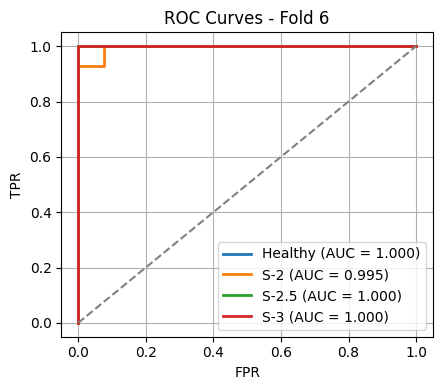

Saved in: evaluations/RNNInceptionTimeMoE_bidirectional_MLPGate_l2_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_fold_06_e20/roc_curves


In [5]:
plot_k_fold_roc_curves_multiclass_v2(
    fpr_folds=moe_metrics['fpr_multiclass_list']['folds'],
    tpr_folds=moe_metrics['tpr_multiclass_list']['folds'],
    auc_folds=moe_metrics['roc_auc_multiclass_list']['folds'],
    class_names=["Healthy", "S-2", "S-2.5", "S-3"],
    save_dir=roc_curves_dir,
    i_folds=[i_fold],
)

### MoE Model Confusion Matrices

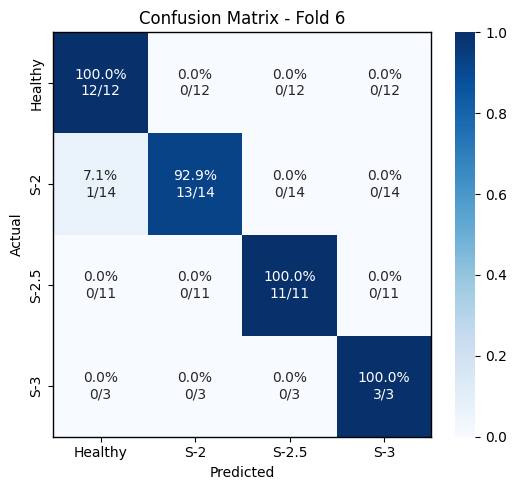

Saved in: evaluations/RNNInceptionTimeMoE_bidirectional_MLPGate_l2_Ga_k10_w500_s500_Ju_k10_w500_s500_w_anomaly_Si_k10_w500_s250_w_anomaly_fold_06_e20/cm


In [6]:
plot_k_fold_cm(
    moe_metrics['cm']['folds'], 
    class_names=["Healthy", "S-2", "S-2.5", "S-3"],
    save_dir=cm_dir,
    figsize=(25,5),
    i_folds=[i_fold],
)

## Gate Model Metrics

In [7]:
print_h("GATE MODEL METRICS", 128)
save_metrics_to_json(gate_metrics, general_metrics_dir, 'gate.json')
print()
pprint(gate_metrics)

                                                       GATE MODEL METRICS                                                       

{'acc': {'avg': 0.947190250507786, 'folds': [0.947190250507786], 'std': 0.0},
 'cm': {'folds': [[[404, 4, 38], [15, 314, 14], [2, 5, 681]]]},
 'f1': {'avg': 0.9468605256091722, 'folds': [0.9468605256091722], 'std': 0.0},
 'precision': {'avg': 0.9482908486352515,
               'folds': [0.9482908486352515],
               'std': 0.0},
 'recall': {'avg': 0.947190250507786, 'folds': [0.947190250507786], 'std': 0.0}}


## Expert-Ga Model Metrics

In [8]:
print_h("EXPERT-Ga MODEL METRICS", 128)
save_metrics_to_json(expert_metrics['Ga'], general_metrics_dir, 'Ga.json')
print()
pprint(expert_metrics['Ga'])

                                                    EXPERT-Ga MODEL METRICS                                                     

{'acc': {'avg': 1.0, 'folds': [1.0], 'std': 0.0},
 'cm': {'folds': [[[5, 0, 0, 0], [0, 6, 0, 0], [0, 0, 3, 0], [0, 0, 0, 2]]]},
 'f1': {'avg': 1.0, 'folds': [1.0], 'std': 0.0},
 'precision': {'avg': 1.0, 'folds': [1.0], 'std': 0.0},
 'recall': {'avg': 1.0, 'folds': [1.0], 'std': 0.0}}


## Expert-Ju Model Metrics

In [9]:
print_h("EXPERT-Ju MODEL METRICS", 128)
save_metrics_to_json(expert_metrics['Ju'], general_metrics_dir, 'Ju.json')
print()
pprint(expert_metrics['Ju'])

                                                    EXPERT-Ju MODEL METRICS                                                     

{'acc': {'avg': 1.0, 'folds': [1.0], 'std': 0.0},
 'cm': {'folds': [[[3, 0, 0, 0], [0, 4, 0, 0], [0, 0, 7, 0], [0, 0, 0, 1]]]},
 'f1': {'avg': 1.0, 'folds': [1.0], 'std': 0.0},
 'precision': {'avg': 1.0, 'folds': [1.0], 'std': 0.0},
 'recall': {'avg': 1.0, 'folds': [1.0], 'std': 0.0}}


## Expert-Si Model Metrics

In [10]:
print_h("EXPERT-Si MODEL METRICS", 128)
save_metrics_to_json(expert_metrics['Si'], general_metrics_dir, 'Si.json')
print()
pprint(expert_metrics['Si'])

                                                    EXPERT-Si MODEL METRICS                                                     

{'acc': {'avg': 0.8888888888888888, 'folds': [0.8888888888888888], 'std': 0.0},
 'cm': {'folds': [[[4, 0, 0, 0], [1, 3, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]]]},
 'f1': {'avg': 0.8871252204585538, 'folds': [0.8871252204585538], 'std': 0.0},
 'precision': {'avg': 0.911111111111111,
               'folds': [0.911111111111111],
               'std': 0.0},
 'recall': {'avg': 0.8888888888888888,
            'folds': [0.8888888888888888],
            'std': 0.0}}
